# YOLOv11 Model #1

#### Torch/CUDA Version

In [1]:
# pip install torch==2.7.1 torchvision==0.22.1 torchaudio==2.7.1 --index-url https://download.pytorch.org/whl/cu128
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU detected")

2.7.1+cu128
True
NVIDIA GeForce RTX 4070 Ti SUPER


#### Config

In [1]:
import os
import glob
import yaml
import numpy as np
from tqdm import tqdm

# Configuration
dataset_name = "datasetv3"
dataset_yaml = dataset_name + ".yaml"  # points to train/val/test and annotations
model_name = "yolo11m.pt"      # YOLO11 medium model
project_name = "yolo11_training"
save_dir = os.path.join("runs", project_name)
save_name = "exp3"
test_images_dir = os.path.join(dataset_name, "train", "images")
epochs = 100
img_size = 1280
batch_size = 2

# Calculate class weights for training data (unused)
def calc_class_weights(dataset_yaml):
    """
    Calculate class weights that are inversely proportional to class sizes to address class imbalance
    
    Args:
        dataset_yaml (str): path to YAML specifying location of training data
    """
    
    # --- Load dataset info ---
    with open(dataset_yaml, "r") as f:
        data_cfg = yaml.safe_load(f)
    
    train_img_dir = data_cfg["train"]
    train_label_dir = train_img_dir.replace("images", "labels")
    
    # --- Load class names ---
    class_names = data_cfg["names"]
    num_classes = len(class_names)
    print(f"Found {num_classes} classes: {class_names}")
    
    # --- Count annotations per class ---
    class_counts = np.zeros(num_classes, dtype=int)
    
    label_files = glob.glob(os.path.join(train_label_dir, "*.txt"))
    for lf in tqdm(label_files, desc="Counting labels"):
        with open(lf, "r") as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) == 5:
                    cls = int(parts[0])
                    if 0 <= cls < num_classes:
                        class_counts[cls] += 1
    
    print(f"\nRaw counts per class:\n{dict(zip(class_names, class_counts))}")
    
    # Compute inverse-frequency weights
    # Avoid divide-by-zero
    class_counts = np.maximum(class_counts, 1)
    inv_freq = 1.0 / class_counts
    weights = inv_freq / inv_freq.min()  # normalize so smallest weight = 1
    
    print("\n📊 Class Weights:")
    for name, w in zip(class_names, weights):
        print(f"{name:20s}: {w:.3f}")

    return weights

#### Training

In [13]:
from ultralytics import YOLO

# Create model object
# (download pretrained YOLO11 model if not already present)
model = YOLO(model_name)

# Train model on training set
model.train(
    data=dataset_yaml,
    epochs=epochs,
    imgsz=img_size,
    batch=batch_size,
    project=save_dir,
    name=save_name,
    nbs=16,
    exist_ok=True  # overwrite if exists
)

# Evaluate the model on validation set
metrics = model.val(data=dataset_yaml)
print("Validation metrics:", metrics)

New https://pypi.org/project/ultralytics/8.3.229 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.216  Python-3.13.2 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=2, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasetv3.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=exp3, nbs=16, nms=False, opse

#### Testing

In [14]:
# Load model
model = YOLO(os.path.join(save_dir, save_name, "weights/best.pt"))

# Evaluate the model on validation set
metrics = model.val(data=dataset_yaml)
print("Validation metrics:", metrics)

# Test on test set
test_results = model.predict(
    source=test_images_dir,
    conf=0.25,
    save=True,
    save_txt=True
)
print("Test predictions saved.")

Ultralytics 8.3.216  Python-3.13.2 torch-2.7.1+cu128 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11m summary (fused): 125 layers, 20,043,910 parameters, 0 gradients, 67.7 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1047.8160.1 MB/s, size: 85.9 KB)
val: Scanning C:\Users\jmani\Local Documents\ALGAE\YOLO11_model\datasetv3\val\labels.cache... 526 images, 113 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 526/526 1.7Mit/s 0.0s0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 33/33 4.2it/s 7.9s0.2s
                   all        526       3920      0.322      0.267      0.238      0.124
                 Algae         69        409      0.537      0.482      0.495      0.266
            Clam Shell         48        254      0.515      0.602      0.585      0.247
     Elodea Canadensis         17         46          0          0     0.0381     0.0121
Eriocaulon Septangulare         29        315      0.408      0.38

#### Example Predictions

{0: 'Algae', 1: 'Clam Shell', 2: 'Elodea Canadensis', 3: 'Eriocaulon Septangulare', 4: 'I. Lacustris', 5: 'Leaves', 6: 'M. Spicatum', 7: 'M. Tenellum', 8: 'Najas', 9: 'P. Amplifolius', 10: 'P. Gramineus', 11: 'P. Perfoliatus', 12: 'P. Praelongus', 13: 'P. Robbinsii', 14: 'P. Zosteriformis', 15: 'Snail', 16: 'Unknown Plant', 17: 'Vallisneria Americana'}

image 1/1 C:\Users\jmani\Local Documents\ALGAE\YOLO11_model\datasetv3\train\images\frame795_795966ms_jpg.rf.d1ec7bfd9b462b238fd5b101596aa312.jpg: 736x1280 14 P. Amplifoliuss, 41.1ms
Speed: 4.6ms preprocess, 41.1ms inference, 72.9ms postprocess per image at shape (1, 3, 736, 1280)
Ground truths:
{'P. Amplifolius': 12}


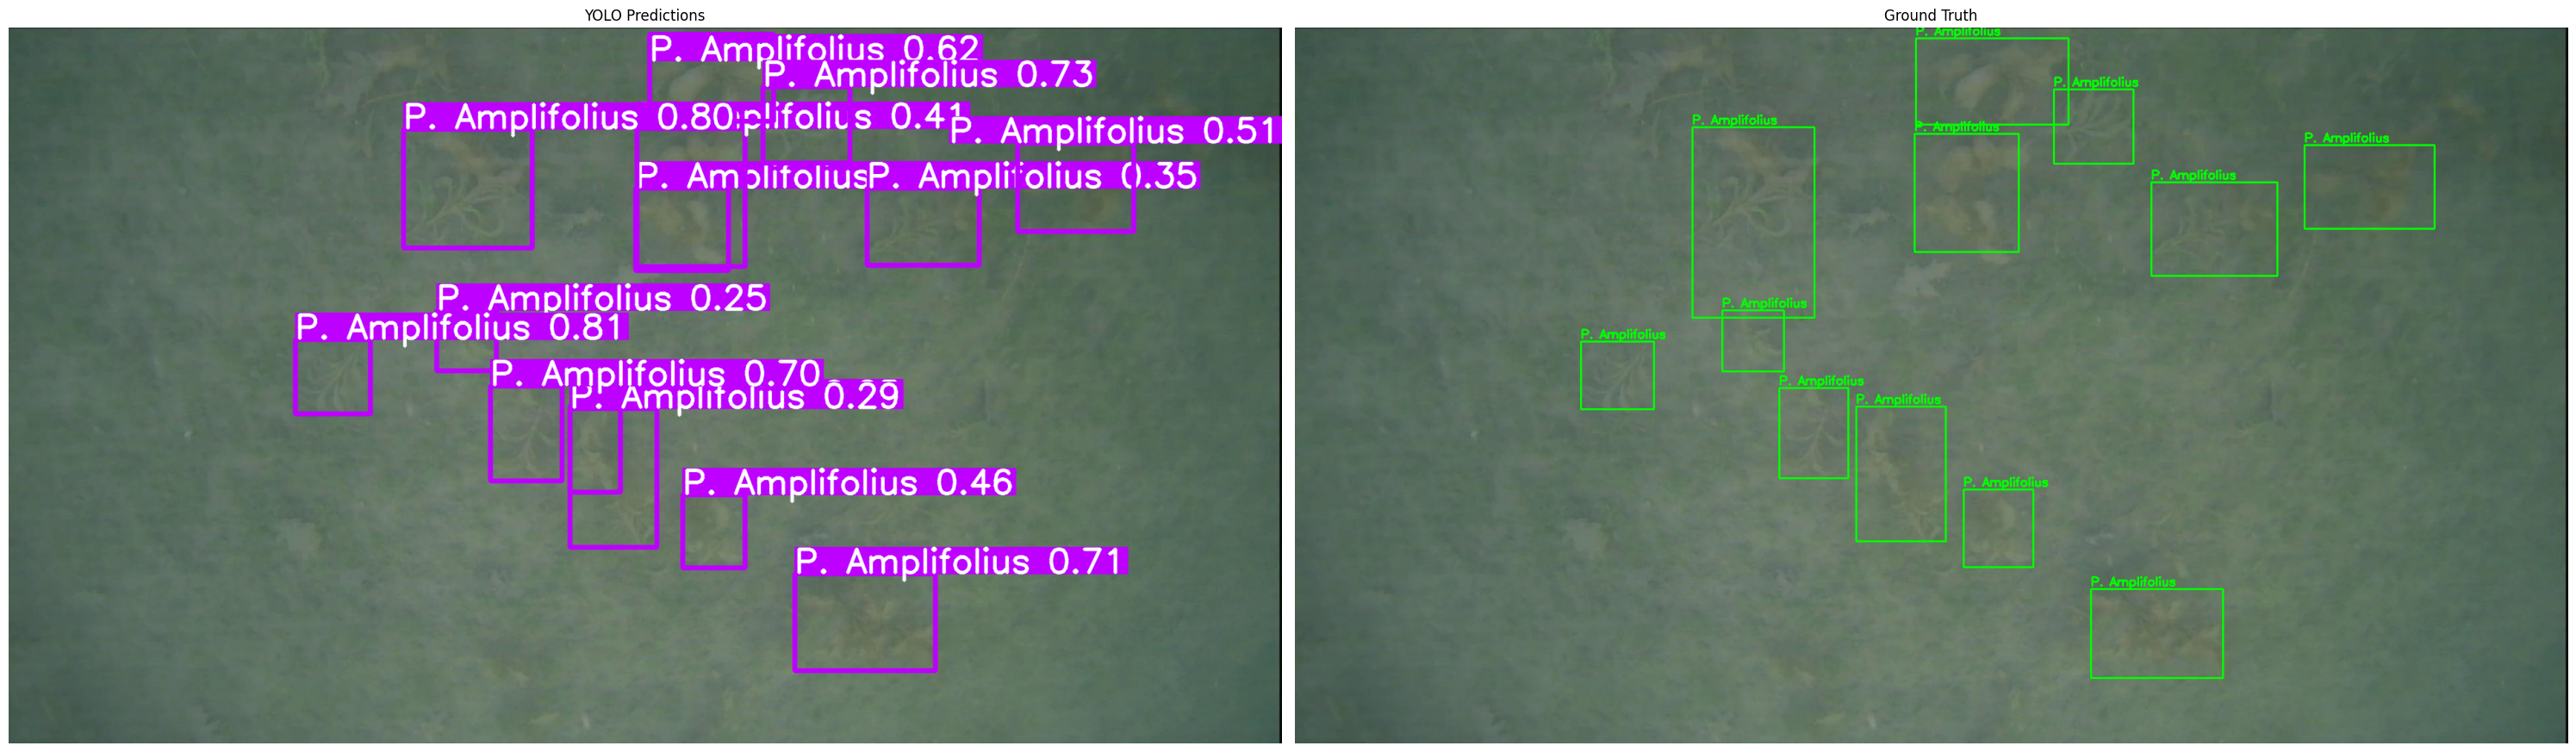


image 1/1 C:\Users\jmani\Local Documents\ALGAE\YOLO11_model\datasetv3\train\images\frame114_114966ms_jpg.rf.e72f6b547fd7717e02ef60e11f2827d1.jpg: 736x1280 3 Algaes, 9.7ms
Speed: 4.3ms preprocess, 9.7ms inference, 2.1ms postprocess per image at shape (1, 3, 736, 1280)
Ground truths:
{'Algae': 9}


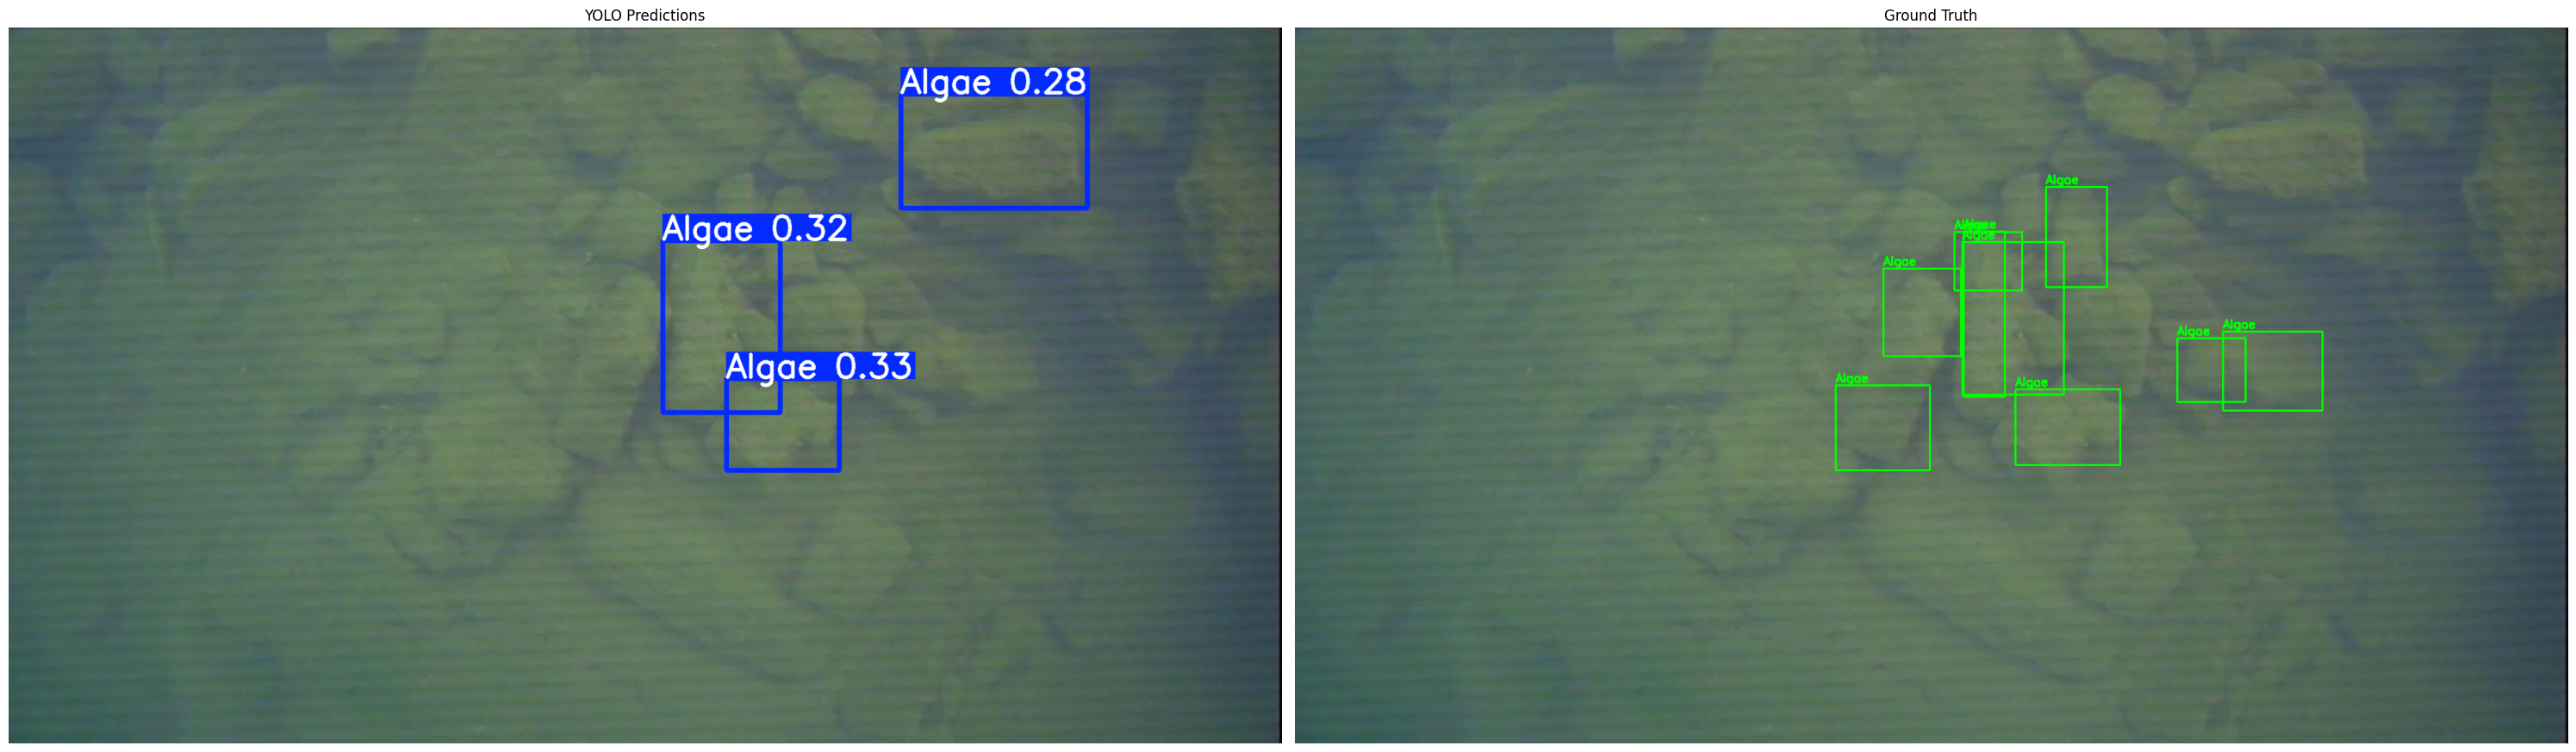


image 1/1 C:\Users\jmani\Local Documents\ALGAE\YOLO11_model\datasetv3\train\images\frame168_168966ms_jpg.rf.8a5b86a03e495c26e63ebb4ed01ae238.jpg: 736x1280 4 Algaes, 1 Clam Shell, 9.7ms
Speed: 4.4ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 736, 1280)
Ground truths:
{'Clam Shell': 1, 'Algae': 5}


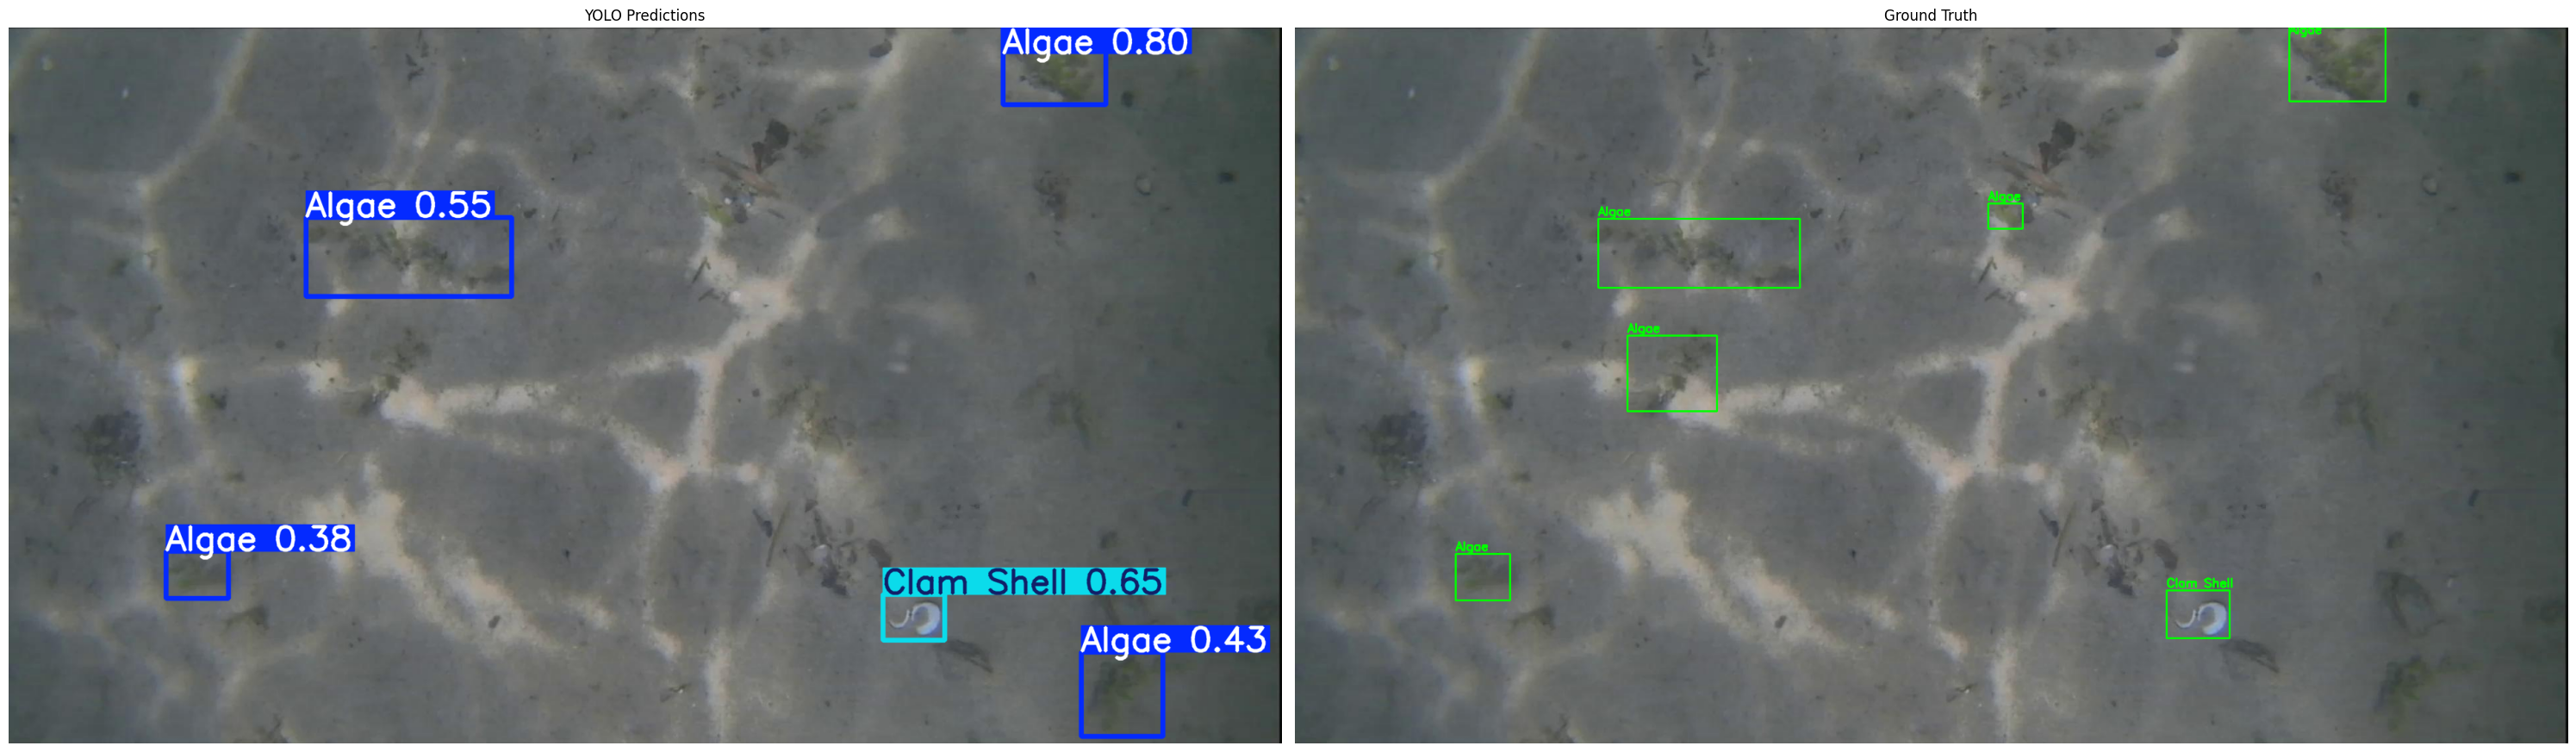


image 1/1 C:\Users\jmani\Local Documents\ALGAE\YOLO11_model\datasetv3\train\images\frame420_420966ms_jpg.rf.5d8473c94096631988ff6ee26a1e82bf.jpg: 736x1280 3 P. Amplifoliuss, 10.1ms
Speed: 4.4ms preprocess, 10.1ms inference, 2.2ms postprocess per image at shape (1, 3, 736, 1280)
Ground truths:
{'P. Amplifolius': 3}


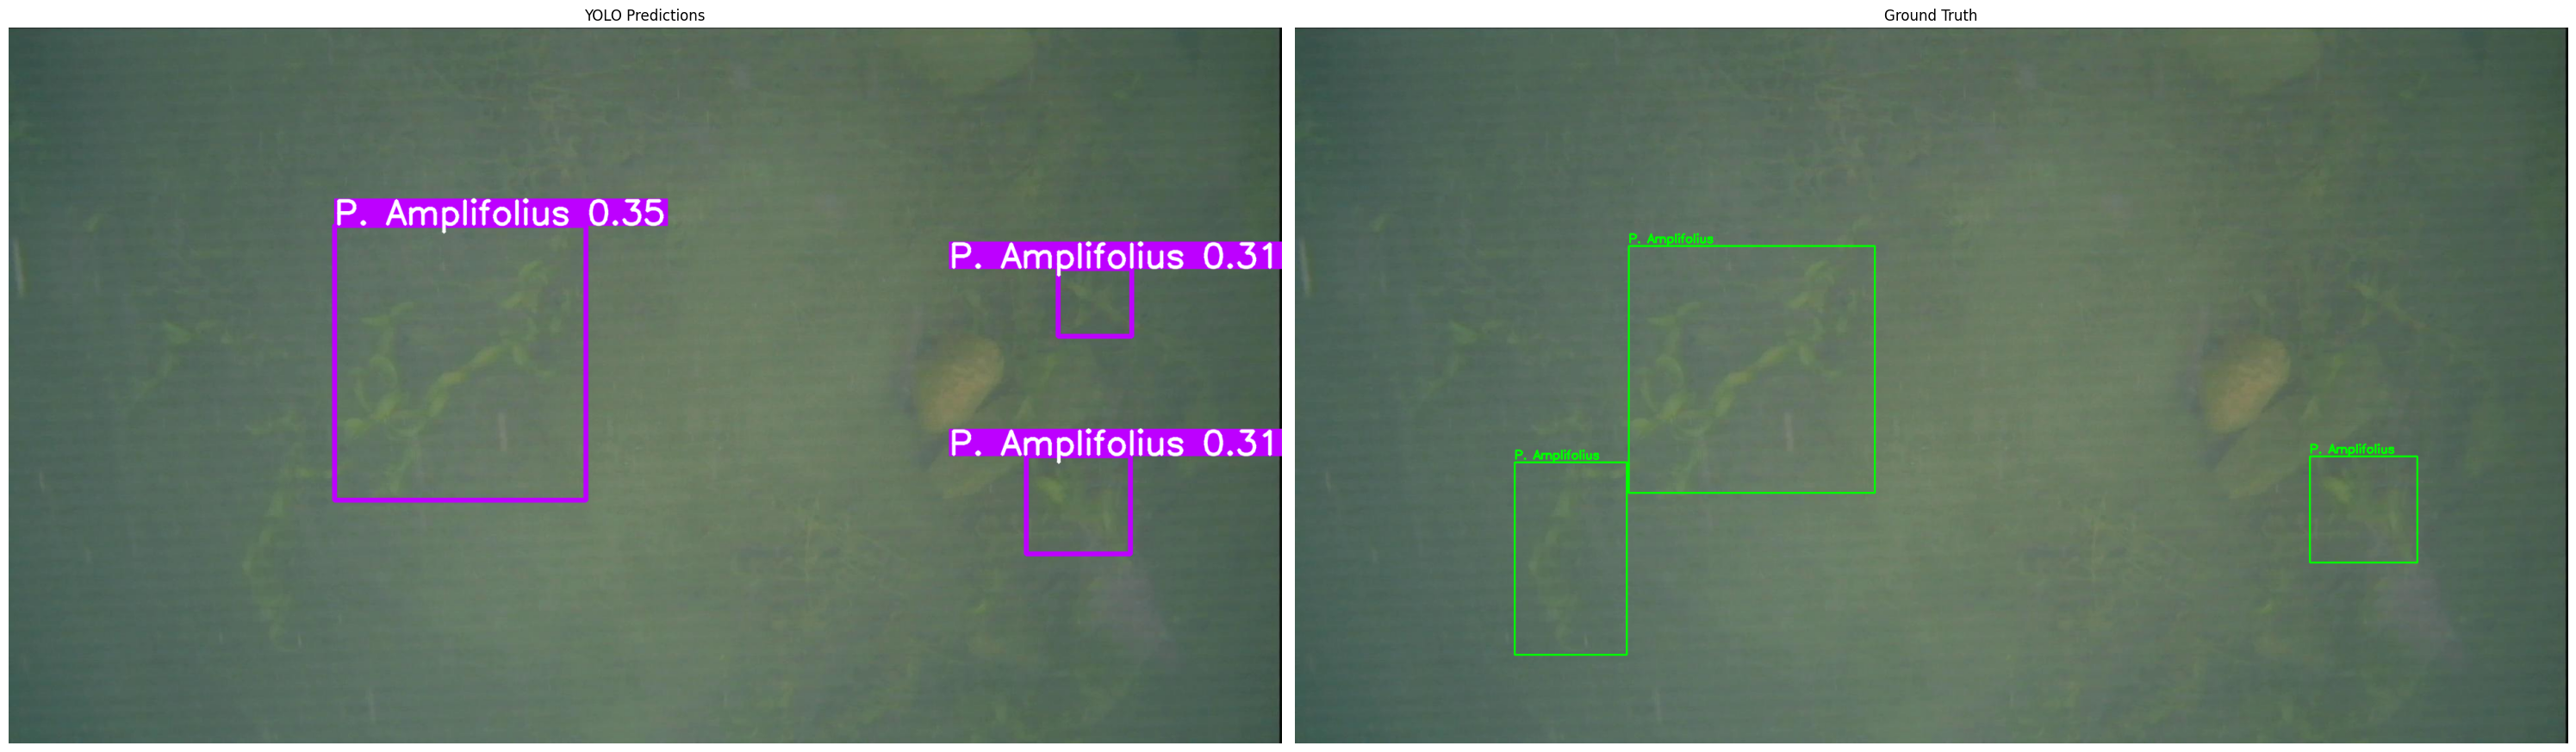

In [2]:
import random, os, glob, cv2
from ultralytics import YOLO
import matplotlib.pyplot as plt
%matplotlib inline

def show_prediction_sample(model, image_dir, count):
    """
    Displays YOLO model predictions side by side with ground truth bounding boxes for count random images in image_dir.
    
    Args:
        model (YOLO model): Trained YOLO model object.
        image_dir (str): Path to image directory.
        count (int): Number of images to display.
    """
    image_files = glob.glob(os.path.join(image_dir, "*.jpg"))
    class_names = model.names
    print(class_names)
    
    for i in range(count):
        image_path = random.choice(image_files)
        results = model.predict(image_path, show=False)
        
        # Get YOLO's prediction image
        pred_img = results[0].plot()

        # Draw ground truth boxes
        gt_img = cv2.imread(image_path)
        label_path = image_path.replace("\\images\\", "\\labels\\").rsplit(".", 1)[0] + ".txt"
        h, w, _ = gt_img.shape
        gt_counts = dict()
        
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    cls, x, y, bw, bh = map(float, line.strip().split())
                    x1, y1 = int((x - bw/2) * w), int((y - bh/2) * h)
                    x2, y2 = int((x + bw/2) * w), int((y + bh/2) * h)

                    # Get class name
                    class_name = class_names[int(cls)] if int(cls) in class_names else str(int(cls))
                    gt_counts[class_name] = gt_counts[class_name] + 1 if class_name in gt_counts.keys() else 1
                    
                    # Draw box and label
                    cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    cv2.putText(gt_img, class_name, (x1, max(y1 - 5, 10)),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

        # Display ground truth counts
        print(f"Ground truths:\n{gt_counts}")
        
        # Convert BGR → RGB for plotting
        pred_img_rgb = cv2.cvtColor(pred_img, cv2.COLOR_BGR2RGB)
        gt_img_rgb = cv2.cvtColor(gt_img, cv2.COLOR_BGR2RGB)

        # Display side by side
        fig, axes = plt.subplots(1, 2, figsize=(30, 15))
        axes[0].imshow(pred_img_rgb)
        axes[0].set_title("YOLO Predictions")
        axes[0].axis("off")
        
        axes[1].imshow(gt_img_rgb)
        axes[1].set_title("Ground Truth")
        axes[1].axis("off")
        
        plt.tight_layout()
        plt.show()
    
# Load your trained YOLO model
model = YOLO(os.path.join(save_dir, save_name, "weights/best.pt"))
show_prediction_sample(model, test_images_dir, 4)

#### Per-image Presence/Absence Metrics

In [7]:
from ultralytics import YOLO
import os
import glob
import numpy as np
from collections import defaultdict

def calc_pa_stats(model, test_images_dir, conf_threshold=0.25, print_tf=True):
    """
    Calculate per-image presence/absence metrics overall and for each class.
    
    Args:
        model (YOLO model): YOLO model object.
        test_images_dir (str): path to image directory.
        conf_threshold (float): detection confidence threshold between presence/absence
    """
    test_labels_dir = test_images_dir.replace("\\images", "\\labels")

    # Load classes
    class_names = model.names  # e.g. {0: 'Algae', 1: 'P. Amplifolius', ...}
    num_classes = len(class_names)

    # Initialize metrics
    TP = defaultdict(int)
    FP = defaultdict(int)
    FN = defaultdict(int)

    # --- Loop over test images ---
    for img_path in glob.glob(os.path.join(test_images_dir, "*.jpg")):
        base = os.path.splitext(os.path.basename(img_path))[0]
        label_path = os.path.join(test_labels_dir, base + ".txt")
    
        # Get ground truth classes for current image
        gt_classes = set()
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 0:
                        gt_classes.add(int(float(parts[0])))
    
        # Skip if there are no ground-truth objects
        if not gt_classes:
            continue
    
        # Run YOLO inference
        results = model.predict(img_path, stream=False, verbose=False)
        preds = results[0].boxes
        pred_classes = set(
            int(c) for c, conf in zip(preds.cls.cpu().numpy(), preds.conf.cpu().numpy())
            if conf > conf_threshold
        )
    
        # Compute TP, FP, FN per class
        for c in range(num_classes):
            if c in gt_classes and c in pred_classes:
                TP[c] += 1
            elif c not in gt_classes and c in pred_classes:
                FP[c] += 1
            elif c in gt_classes and c not in pred_classes:
                FN[c] += 1
    
    # Compute metrics
    print("\nPer-Class Image-Level Metrics:")
    overall_tp = overall_fp = overall_fn = 0
    macro_precs = []
    macro_recs = []
    macro_f1s = []
    
    for c, name in class_names.items():
        tp, fp, fn = TP[c], FP[c], FN[c]
        prec = tp / (tp + fp) if tp + fp > 0 else 0
        rec = tp / (tp + fn) if tp + fn > 0 else 0
        f1 = (2 * prec * rec) / (prec + rec) if prec + rec > 0 else 0
        print(f"{name:<15}  P={prec:.3f}  R={rec:.3f}  F1={f1:.3f}", end="")

        if print_tf:
            print(f"(TP={tp}, FP={fp}, FN={fn})")
        else:
            print()
            
        overall_tp += tp
        overall_fp += fp
        overall_fn += fn
        macro_precs.append(prec)
        macro_recs.append(rec)
        macro_f1s.append(f1)
    
    # Micro metrics
    micro_prec = overall_tp / (overall_tp + overall_fp) if (overall_tp + overall_fp) > 0 else 0
    micro_rec = overall_tp / (overall_tp + overall_fn) if (overall_tp + overall_fn) > 0 else 0
    micro_f1 = (2 * micro_prec * micro_rec) / (micro_prec + micro_rec) if (micro_prec + micro_rec) > 0 else 0

    # Macro metrics
    macro_prec = np.mean(macro_precs)
    macro_rec = np.mean(macro_recs)
    macro_f1 = np.mean(macro_f1s)
    
    print(f"\nMicro Precision={micro_prec:.3f}, Recall={micro_rec:.3f}, F1={micro_f1:.3f}")
    print(f"Macro Precision={macro_prec:.3f}, Recall={macro_rec:.3f}, F1={macro_f1:.3f}")

conf = 0.25
model = YOLO(os.path.join(save_dir, save_name, "weights/best.pt"))
calc_pa_stats(model, test_images_dir, conf_threshold=conf, print_tf=False)


Per-Class Image-Level Metrics:
Algae            P=0.893  R=0.738  F1=0.808
Clam Shell       P=0.934  R=0.885  F1=0.909
Elodea Canadensis  P=0.944  R=0.531  F1=0.680
Eriocaulon Septangulare  P=0.822  R=0.763  F1=0.791
I. Lacustris     P=0.000  R=0.000  F1=0.000
Leaves           P=0.812  R=0.650  F1=0.722
M. Spicatum      P=1.000  R=0.069  F1=0.129
M. Tenellum      P=1.000  R=0.053  F1=0.100
Najas            P=0.750  R=0.211  F1=0.329
P. Amplifolius   P=0.947  R=0.938  F1=0.942
P. Gramineus     P=0.796  R=0.582  F1=0.672
P. Perfoliatus   P=0.697  R=0.702  F1=0.700
P. Praelongus    P=0.814  R=0.748  F1=0.780
P. Robbinsii     P=0.947  R=0.807  F1=0.871
P. Zosteriformis  P=0.733  R=0.686  F1=0.709
Snail            P=0.917  R=0.458  F1=0.611
Unknown Plant    P=0.731  R=0.211  F1=0.328
Vallisneria Americana  P=0.721  R=0.721  F1=0.721

Micro Precision=0.875, Recall=0.721, F1=0.791
Macro Precision=0.803, Recall=0.542, F1=0.600
